# Introduction

**"It Was The Ship Of Dreams."**

This was one of the famous dialog from the Titanic movie, and it was so true.

RMS Titanic was a British passenger liner, the largest ship afloat at the time she entered service. Titanic sank in the North Atlantic Ocean on 15 April 1912 after striking an iceberg during her maiden voyage from Southampton, UK, to New York City. Of the estimated 2,224 passengers and crew aboard, more than 1,500 died, which made the sinking possibly one of the deadliest for a single ship up to that time.
I always used to wonder whether it's possible to save as many as possible people from the ship. We didn't get a chance to save them, but fortunately, this dataset provide us the opportunity to predict it :) 

In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix
from sklearn import preprocessing    
le = preprocessing.LabelEncoder()

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
%matplotlib inline 

In [2]:
from sklearn.ensemble import RandomForestClassifier

In [3]:
titanic_train_df = pd.read_csv('../input/titanic/train.csv')
titanic_test_df  = pd.read_csv('../input/titanic/test.csv')

In [4]:
titanic_train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
titanic_train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
titanic_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
n = titanic_train_df.nunique(axis=0)  
print("No.of.unique values in each column :\n", n)

No.of.unique values in each column :
 PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64


In [8]:
titanic_train_df.shape

(891, 12)

# Exploratory Data Analysis(EDA)

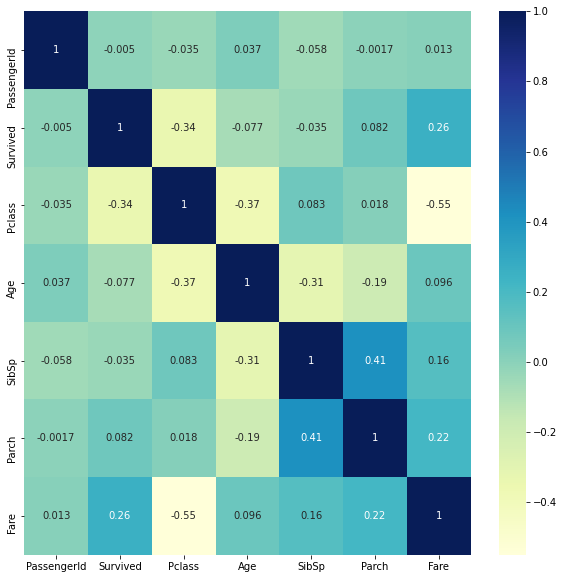

In [9]:
plt.figure(figsize=(10,10))
g=sns.heatmap(titanic_train_df.corr(),annot=True,cmap="YlGnBu")

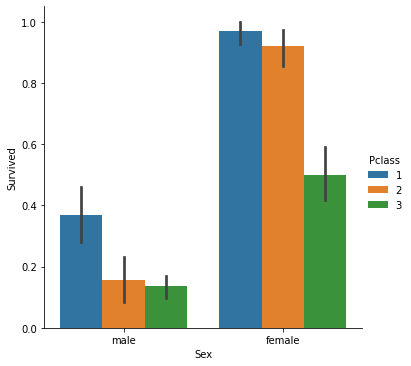

In [10]:
sns.catplot(x="Sex", y="Survived", hue="Pclass", kind="bar", data=titanic_train_df)

<AxesSubplot:xlabel='SibSp', ylabel='Count'>

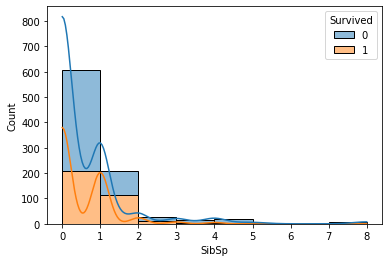

In [11]:
sns.histplot(data=titanic_train_df, x="SibSp", binwidth=1,hue="Survived", multiple="stack", kde=True)

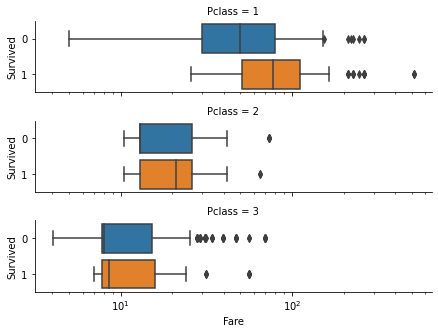

In [12]:
g = sns.catplot(x="Fare", y="Survived", row="Pclass", kind="box", orient="h", height=1.5, aspect=4,
                data=titanic_train_df.query("Fare > 0"))
g.set(xscale="log")

<AxesSubplot:xlabel='Survived', ylabel='Fare'>

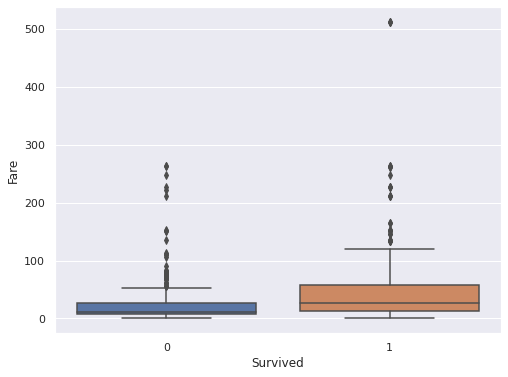

In [13]:
sns.set(rc={'figure.figsize':(8,6)})
sns.boxplot(x='Survived', y='Fare', data=titanic_train_df)

<AxesSubplot:xlabel='Age', ylabel='Fare'>

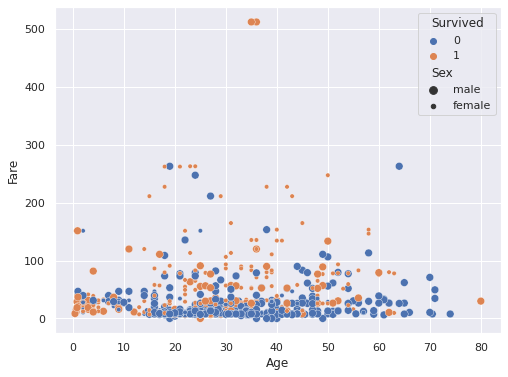

In [14]:
sns.scatterplot(data=titanic_train_df, x='Age', y='Fare',hue="Survived",
                size='Sex', sizes=(20, 60), legend="full")

<AxesSubplot:xlabel='Age', ylabel='Count'>

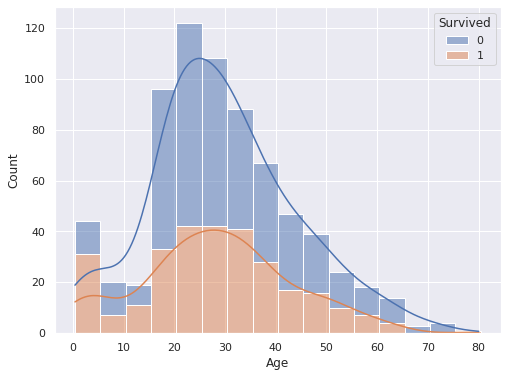

In [15]:
sns.histplot(data=titanic_train_df, x="Age", binwidth=5,hue="Survived", multiple="stack", kde=True)

Lets start with **Title** column, as we see there are multiple Title, which may depict same values, so its better we do text correct. Ex. Ms and Miss both are same. Mme actual meaning is Mrs. Other values may not help us in algorithm, its better we convert these values to one value. I have used 'Other'

# Feature Engineering

We have 3 entries with Ticket fare more than 500, as we dont have lot of rows. We can handle this outlier rather than removing it. I have taken mean of Fare, and assigned it to outlier

In [16]:
titanic_train_df.loc[titanic_train_df['Fare'] > 500, 'Fare'] = titanic_train_df['Fare'].mean()

In [17]:
def findtitle(line):   
    splitLine = line.split(',')
    name = splitLine[1].split('.')
    title = name[0].strip()
    return title

In [18]:
titanic_train_df['Title'] = titanic_train_df['Name'].apply(findtitle)
titanic_test_df['Title'] = titanic_test_df['Name'].apply(findtitle)

In [19]:
titanic_train_df['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

In [20]:
titanic_train_df['Title'] = titanic_train_df['Title'].replace(to_replace =["Lady", "Countess","Capt", "Col","Don", "Dr", "Major", "Rev", "Sir", "Jonkheer","Dona","the Countess"], value ="Other")
titanic_train_df['Title'] = titanic_train_df['Title'].replace('Mlle', 'Miss')
titanic_train_df['Title'] = titanic_train_df['Title'].replace('Ms', 'Miss')
titanic_train_df['Title'] = titanic_train_df['Title'].replace('Mme', 'Mrs')


<AxesSubplot:xlabel='Title', ylabel='Count'>

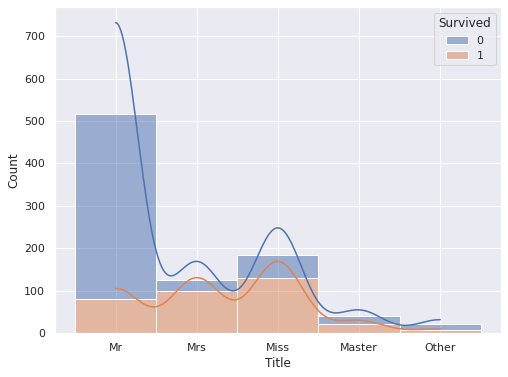

In [21]:
sns.histplot(data=titanic_train_df, x="Title", binwidth=1,hue="Survived", multiple="stack", kde=True)

In [22]:
titanic_train_df['Title'] = le.fit_transform(titanic_train_df['Title'])

In [23]:
titanic_test_df['Title'] = titanic_test_df['Title'].replace(to_replace =["Lady", "Countess","Capt", "Col","Don", "Dr", "Major", "Rev", "Sir", "Jonkheer","Dona","the Countess"], value ="Other")
titanic_test_df['Title'] = titanic_test_df['Title'].replace('Mlle', 'Miss')
titanic_test_df['Title'] = titanic_test_df['Title'].replace('Ms', 'Miss')
titanic_test_df['Title'] = titanic_test_df['Title'].replace('Mme', 'Mrs')

In [24]:
titanic_test_df['Title'] = le.fit_transform(titanic_test_df['Title'])

In [25]:
def getTicketDetail(ticket):
    split_data = ticket.split(" ")
    if len(split_data) > 1:
        return split_data[0]
    else:
        return "Other"

In [26]:
titanic_train_df['Ticket'] = titanic_train_df['Ticket'].apply(getTicketDetail)
titanic_test_df['Ticket'] = titanic_test_df['Ticket'].apply(getTicketDetail)

In [27]:
titanic_train_df['Ticket'] = titanic_train_df['Ticket'].str.replace(".","")
titanic_train_df['Ticket'] = titanic_train_df['Ticket'].str.replace("/","")
titanic_test_df['Ticket'] = titanic_test_df['Ticket'].str.replace(".","")
titanic_test_df['Ticket'] = titanic_test_df['Ticket'].str.replace("/","")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  This is separate from the ipykernel package so we can avoid doing imports until


In [28]:
titanic_train_df['Ticket'].value_counts()

Other      665
PC          60
CA          41
A5          21
SOTONOQ     15
STONO       12
WC          10
A4           7
SCPARIS      7
STONO2       6
SOC          6
C            5
FCC          5
SCParis      4
SOPP         3
PP           3
WEP          3
SCAH         3
SWPP         2
PPP          2
SOTONO2      2
FC           1
Fa           1
SC           1
SOP          1
SCA4         1
AS           1
CASOTON      1
SCOW         1
SP           1
Name: Ticket, dtype: int64

In [29]:
titanic_train_df['Ticket'] = titanic_train_df['Ticket'].str.replace("SOTONO2","SOTONOQ")
titanic_test_df['Ticket'] = titanic_test_df['Ticket'].str.replace("SOTONO2","SOTONOQ")
titanic_train_df['Ticket'] = titanic_train_df['Ticket'].str.replace("CASOTON","SOTONOQ")
titanic_test_df['Ticket'] = titanic_test_df['Ticket'].str.replace("CASOTON","SOTONOQ")

titanic_train_df['Ticket'] = titanic_train_df['Ticket'].str.replace("SCAH","SC")
titanic_test_df['Ticket'] = titanic_test_df['Ticket'].str.replace("SCAH","SC")
titanic_train_df['Ticket'] = titanic_train_df['Ticket'].str.replace("SCA4","SC")
titanic_test_df['Ticket'] = titanic_test_df['Ticket'].str.replace("SCA4","SC")
titanic_train_df['Ticket'] = titanic_train_df['Ticket'].str.replace("SCAH","SC")
titanic_test_df['Ticket'] = titanic_test_df['Ticket'].str.replace("SCAH","SC")

titanic_train_df['Ticket'] = titanic_train_df['Ticket'].str.replace("SCParis","SCPARIS")
titanic_test_df['Ticket'] = titanic_test_df['Ticket'].str.replace("SCParis","SCPARIS")

In [30]:
titanic_train_df['Ticket'] = titanic_train_df['Ticket'].str.replace("SP","Other")
titanic_test_df['Ticket'] = titanic_test_df['Ticket'].str.replace("SP","Other")
titanic_train_df['Ticket'] = titanic_train_df['Ticket'].str.replace("Fa","Other")
titanic_test_df['Ticket'] = titanic_test_df['Ticket'].str.replace("Fa","Other")

titanic_train_df['Ticket'] = titanic_train_df['Ticket'].str.replace("AS","Other")
titanic_test_df['Ticket'] = titanic_test_df['Ticket'].str.replace("AS","Other")
titanic_train_df['Ticket'] = titanic_train_df['Ticket'].str.replace("FC","Other")
titanic_test_df['Ticket'] = titanic_test_df['Ticket'].str.replace("FC","Other")
titanic_train_df['Ticket'] = titanic_train_df['Ticket'].str.replace("SCOW","Other")
titanic_test_df['Ticket'] = titanic_test_df['Ticket'].str.replace("SCOW","Other")

titanic_train_df['Ticket'] = titanic_train_df['Ticket'].str.replace("SOP","Other")
titanic_test_df['Ticket'] = titanic_test_df['Ticket'].str.replace("SOP","Other")

In [31]:
titanic_train_df['Ticket'] = le.fit_transform(titanic_train_df['Ticket'])
titanic_test_df['Ticket'] = le.fit_transform(titanic_test_df['Ticket'])

<AxesSubplot:xlabel='Ticket', ylabel='Fare'>

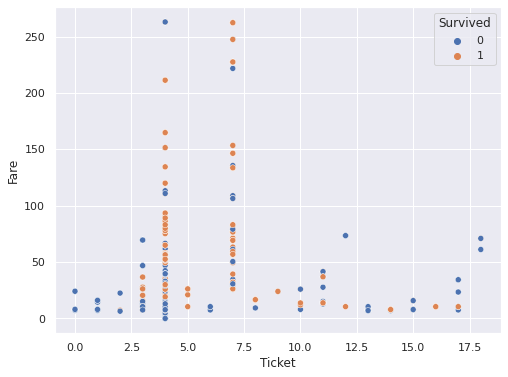

In [32]:
sns.scatterplot(data=titanic_train_df, x='Ticket', y='Fare',hue="Survived", sizes=(20, 60), legend="full")

In [33]:
def missing_percent_of_column(train_set):
    nan_percent = 100*(train_set.isnull().sum()/len(train_set))
    nan_percent = nan_percent[nan_percent>0].sort_values(ascending=False).round(1)
    DataFrame = pd.DataFrame(nan_percent)
    # Rename the columns
    mis_percent_table = DataFrame.rename(columns = {0 : '% of Misiing Values'}) 
    # Sort the table by percentage of missing descending
    mis_percent = mis_percent_table
    return mis_percent

In [34]:
miss = missing_percent_of_column(titanic_train_df)
miss

,% of Misiing Values
Cabin,77.1
Age,19.9
Embarked,0.2


As most of the values for **Cabin** are not present, we can drop that column.

**Age** is one of the important columns, so even if almost 20% values do not exist, still we can not drop that column.

**PassengerId, Name** columns won't help in deciding whether a person has survived or not, so we can drop these columns.

In [35]:
titanic_train_df = titanic_train_df.drop(['PassengerId','Cabin','Name'], axis=1)
titanic_test_df = titanic_test_df.drop(['Cabin','Name'], axis=1)

In [36]:
titanic_train_df.Fare = titanic_train_df.groupby(['Pclass', 'Parch', 'SibSp'])['Fare'].apply(lambda x: x.fillna(x.mean()))

In [37]:
titanic_test_df.Fare = titanic_test_df.groupby(['Pclass', 'Parch', 'SibSp'])['Fare'].apply(lambda x: x.fillna(x.mean()))

In [38]:
titanic_train_df['Fare'] = titanic_train_df['Fare'].round(0).astype(int)
titanic_test_df['Fare'] = titanic_test_df['Fare'].round(0)

In [39]:
# Get one hot encoding of columns 'vehicleType'
one_hot = pd.get_dummies(titanic_train_df['Embarked'])
# Drop column as it is now encoded
titanic_train_df = titanic_train_df.drop('Embarked',axis = 1)
# Join the encoded df
titanic_train_df = titanic_train_df.join(one_hot)
titanic_train_df 

# Get one hot encoding of columns 'vehicleType'
one_hot = pd.get_dummies(titanic_test_df['Embarked'])
# Drop column as it is now encoded
titanic_test_df = titanic_test_df.drop('Embarked',axis = 1)
# Join the encoded df
titanic_test_df = titanic_test_df.join(one_hot)
titanic_test_df 

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Title,C,Q,S
0,892,3,male,34.5,0,0,8,8.0,2,0,1,0
1,893,3,female,47.0,1,0,8,7.0,3,0,0,1
2,894,2,male,62.0,0,0,8,10.0,2,0,1,0
3,895,3,male,27.0,0,0,8,9.0,2,0,0,1
4,896,3,female,22.0,1,1,8,12.0,3,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,male,NaN,0,0,2,8.0,2,0,0,1
414,1306,1,female,39.0,0,0,11,109.0,4,1,0,0
415,1307,3,male,38.5,0,0,17,7.0,2,0,0,1
416,1308,3,male,NaN,0,0,8,8.0,2,0,0,1


In [40]:

# Get one hot encoding of columns 'vehicleType'
one_hot = pd.get_dummies(titanic_train_df['Sex'])
# Drop column as it is now encoded
titanic_train_df = titanic_train_df.drop('Sex',axis = 1)
# Join the encoded df
titanic_train_df = titanic_train_df.join(one_hot)
titanic_train_df 

# Get one hot encoding of columns 'vehicleType'
one_hot = pd.get_dummies(titanic_test_df['Sex'])
# Drop column as it is now encoded
titanic_test_df = titanic_test_df.drop('Sex',axis = 1)
# Join the encoded df
titanic_test_df = titanic_test_df.join(one_hot)
titanic_test_df 

,PassengerId,Pclass,Age,SibSp,Parch,Ticket,Fare,Title,C,Q,S,female,male
0,892,3,34.5,0,0,8,8.0,2,0,1,0,0,1
1,893,3,47.0,1,0,8,7.0,3,0,0,1,1,0
2,894,2,62.0,0,0,8,10.0,2,0,1,0,0,1
3,895,3,27.0,0,0,8,9.0,2,0,0,1,0,1
4,896,3,22.0,1,1,8,12.0,3,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,NaN,0,0,2,8.0,2,0,0,1,0,1
414,1306,1,39.0,0,0,11,109.0,4,1,0,0,1,0
415,1307,3,38.5,0,0,17,7.0,2,0,0,1,0,1
416,1308,3,NaN,0,0,8,8.0,2,0,0,1,0,1


In [41]:
titanic_train_df['TotFam'] = titanic_train_df['SibSp'] + titanic_train_df['Parch'] + 1
titanic_test_df['TotFam'] = titanic_test_df['SibSp'] + titanic_test_df['Parch'] + 1

In [42]:
titanic_train_df = titanic_train_df.drop(['SibSp','Parch'], axis=1)
titanic_test_df = titanic_test_df.drop(['SibSp','Parch'], axis=1)

In [43]:
titanic_train_df['IsAlone'] = 0
titanic_test_df['IsAlone'] = 0

In [44]:
titanic_train_df.loc[titanic_train_df['TotFam'] == 1, 'IsAlone'] = 1
titanic_test_df.loc[titanic_test_df['TotFam'] == 1, 'IsAlone'] = 1

In [45]:
titanic_train_df.Age = titanic_train_df.groupby(['Title'])['Age'].apply(lambda x: x.fillna(x.mean()))
titanic_test_df.Age = titanic_test_df.groupby(['Title'])['Age'].apply(lambda x: x.fillna(x.mean()))

In [46]:
titanic_train_df.head(5)

,Survived,Pclass,Age,Ticket,Fare,Title,C,Q,S,female,male,TotFam,IsAlone
0,0,3,22.0,1,7,2,0,0,1,0,1,2,0
1,1,1,38.0,7,71,3,1,0,0,1,0,2,0
2,1,3,26.0,15,8,1,0,0,1,1,0,1,1
3,1,1,35.0,4,53,3,0,0,1,1,0,2,0
4,0,3,35.0,4,8,2,0,0,1,0,1,1,1


In [47]:
titanic_train_df = titanic_train_df.drop(['female','Q'], axis=1)
titanic_test_df = titanic_test_df.drop(['female','Q'], axis=1)

In [48]:
X_train = titanic_train_df.drop("Survived", axis=1)
Y_train = titanic_train_df["Survived"]
X_test  = titanic_test_df.drop("PassengerId", axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

((891, 10), (891,), (418, 10))

The MinMaxscaler is a type of scaler that transform features by scaling each feature the minimum and maximum values to be 0 and 1 respectively.

You can review more details on below link,

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

In [49]:
# data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler

# fit scaler on training data
norm = MinMaxScaler().fit(X_train)

# transform training data
X_train = norm.transform(X_train)

# transform testing dataabs
X_test = norm.transform(X_test)

# Model Training & Prediction

We will be using CatBoost alogrithm. As this is ensemble learning boosting algorithm, its performance is largly depend on hyperparameter tuning.
Lets first do the HyperParaMeter tuning with the help of GridSearchCV.

In [50]:
rfc_single = RandomForestClassifier(criterion='gini', n_estimators=1750, max_depth=7, min_samples_split=6,
                                    min_samples_leaf=6, max_features='auto', oob_score=True, random_state=42,  n_jobs=-1,  verbose=1) 

In [51]:
rfc_single.fit(X_train, Y_train)

print("Performance on train data:", rfc_single.score(X_train, Y_train))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    4.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.4s


Performance on train data: 0.8585858585858586


[Parallel(n_jobs=4)]: Done 1750 out of 1750 | elapsed:    0.6s finished


In [52]:
# Get predictions
y_pred = rfc_single.predict(X_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 1750 out of 1750 | elapsed:    0.5s finished


In [53]:
#Create a  DataFrame with the passengers ids and our prediction
submission = pd.DataFrame({'PassengerId':titanic_test_df['PassengerId'],'Survived':y_pred})

#Visualize the first 5 rows
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [54]:
filename = 'submission.csv'

submission.to_csv(filename,index=False)

print('Saved file: ' + filename)

Saved file: submission.csv
